In [13]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import common

In [14]:
analytical_retardation_type = "langmuir"

In [15]:
base_dir = Path(f"../data_out/{analytical_retardation_type}/finn_c_plus_noise_epochs_10")

df = {
    "finn_dir": [],
    "ret_file_path": [],
    "sigma": [],
    "run_ID": [],
}
for finn_dir, ret_file_path in common.iter_final_retardation_files(base_dir, min_epoch=10, verbose=False):
    pattern = r"cFullNoise_sigma=(?P<sigma>\d+\.\d+)_j=(?P<j>\d+)"
    string = finn_dir.name
    match = re.match(pattern, string)
    if match:
        result_dict = match.groupdict()
    else:
        raise ValueError(f"Could not parse {string}")

    df["finn_dir"].append(finn_dir)
    df["ret_file_path"].append(ret_file_path)
    df["sigma"].append(float(result_dict["sigma"]))
    df["run_ID"].append(int(result_dict["j"]))

df = pd.DataFrame(df)  # .sort_values("sigma").reset_index(drop=True)
print(len(df))
df.head()

35


,finn_dir,ret_file_path,sigma,run_ID
0,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,0
1,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,7
2,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,6
3,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,1
4,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.016,0


In [16]:
c_train_original = np.load(f"../data/FINN_forward_solver/retardation_{analytical_retardation_type}/c_train.npy")[
    :51, ..., None
]

In [17]:
df["c_train_MSE"] = df.apply(
    lambda x: np.mean(
        np.square(np.load(x["finn_dir"] / "c_train.npy") - c_train_original)
    ),
    axis=1,
)
df["c_pred_MSE_ideal"] = df.apply(
    lambda x: np.mean(
        np.square(np.load(x["finn_dir"] / "c_predictions.npy") - c_train_original)
    ),
    axis=1,
)
df["c_pred_MSE_real"] = df.apply(
    lambda x: np.mean(
        np.square(
            np.load(x["finn_dir"] / "c_predictions.npy")
            - np.load(x["finn_dir"] / "c_train.npy")
        )
    ),
    axis=1,
)
df.head()

,finn_dir,ret_file_path,sigma,run_ID,c_train_MSE,c_pred_MSE_ideal,c_pred_MSE_real
0,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,0,0.000016,0.000082,0.000094
1,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,7,0.000016,0.000096,0.000110
2,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,6,0.000017,0.000074,0.000090
3,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.004,1,0.000016,0.000190,0.000206
4,../data_out/langmuir/finn_c_plus_noise_epochs_...,../data_out/langmuir/finn_c_plus_noise_epochs_...,0.016,0,0.000254,0.000469,0.000690


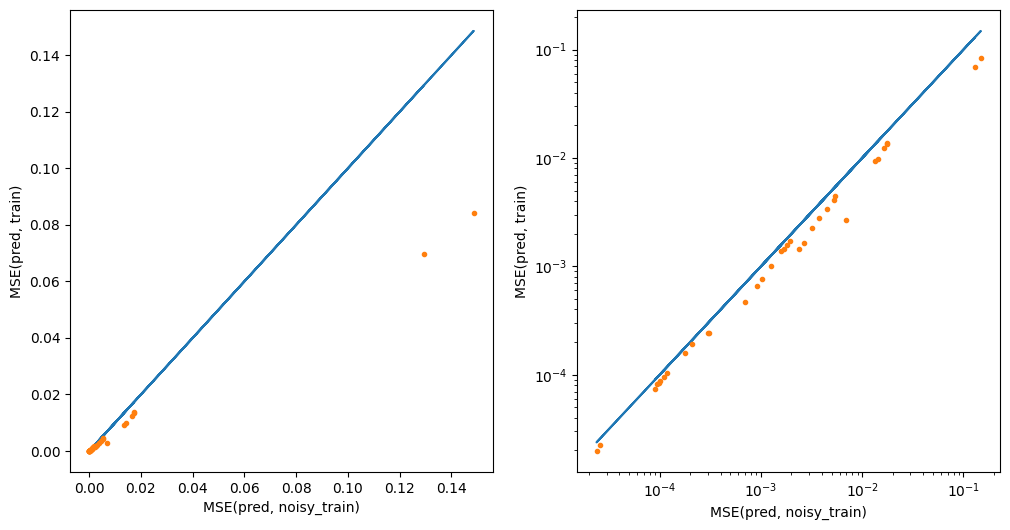

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.plot(df["c_pred_MSE_real"], df["c_pred_MSE_real"], "-")
ax1.plot(df["c_pred_MSE_real"], df["c_pred_MSE_ideal"], ".")
ax1.set_xlabel("MSE(pred, noisy_train)")
ax1.set_ylabel("MSE(pred, train)")

ax2.loglog(df["c_pred_MSE_real"], df["c_pred_MSE_real"], "-")
ax2.loglog(df["c_pred_MSE_real"], df["c_pred_MSE_ideal"], ".")
ax2.set_xlabel("MSE(pred, noisy_train)")
ax2.set_ylabel("MSE(pred, train)")

plt.show()

MSE with noisy training data is higher than error on clean data => No overfitting

Also, every step in MSE is when there is a step in sigma (probably). (As seen in the below plot.)

------

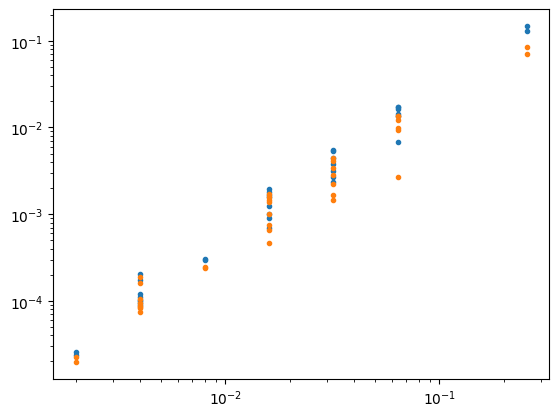

In [19]:
# plt.plot(df["sigma"], df["sigma"], "-")
plt.loglog(df["sigma"], df["c_pred_MSE_real"], ".")
plt.loglog(df["sigma"], df["c_pred_MSE_ideal"], ".")
plt.show()

C-Error increases with increasing noise. TODO: Not really expected for the orange ones. At least it is slower than the real MSE. But ideally, it would only increase insignificantly.

-----

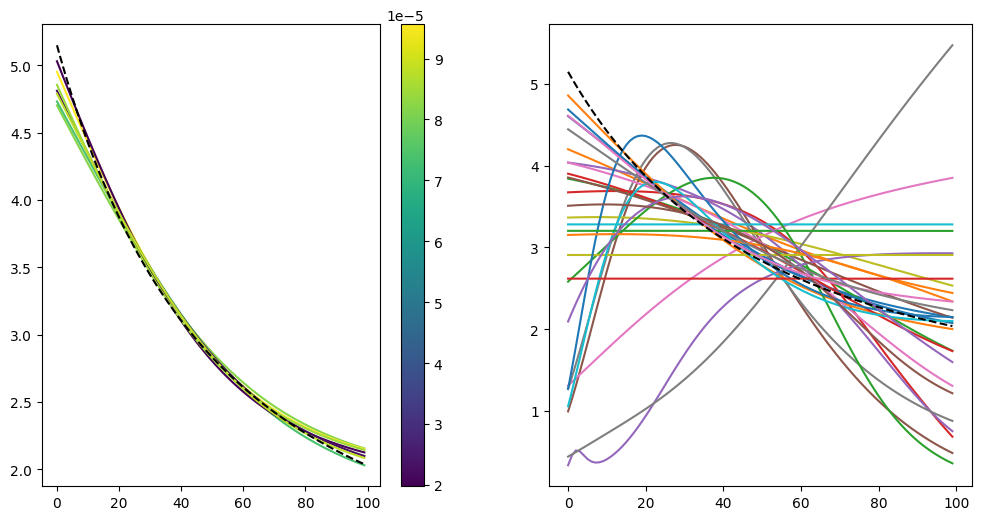

In [25]:
MSE_threshold_type = "c_pred_MSE_ideal"
# MSE_threshold_type = "c_pred_MSE_real"  # same problem as ideal

values = df[df[MSE_threshold_type] < 1e-4][MSE_threshold_type].values

colormap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=values.min(), vmax=values.max())

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

for i, ret_file_path in enumerate(df["ret_file_path"]):
    ret = np.load(ret_file_path)
    color = colormap(norm(df[MSE_threshold_type].iloc[i]))
    if df[MSE_threshold_type].iloc[i] < 1e-4:
        ax1.plot(ret, color=color)
    else:
        ax2.plot(ret)  # , color=color)

analytical_retardation = np.load(f"../data_out/{analytical_retardation_type}/default_finn/retardation_{analytical_retardation_type}.npy")

ax1.plot(analytical_retardation, "k--")
ax2.plot(analytical_retardation, "k--")

# Create ScalarMappable
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

# Add colorbar to ax1
plt.colorbar(sm, ax=ax1)

if analytical_retardation_type == "freundlich":
    ax1.set_ylim(3, 5)
    ax2.set_ylim(3, 5)

plt.show()

So there are a few rets which produce small (< 1e-4) MSE for c even though they look quite bad (completely constant). 

In [21]:
import seaborn as sns

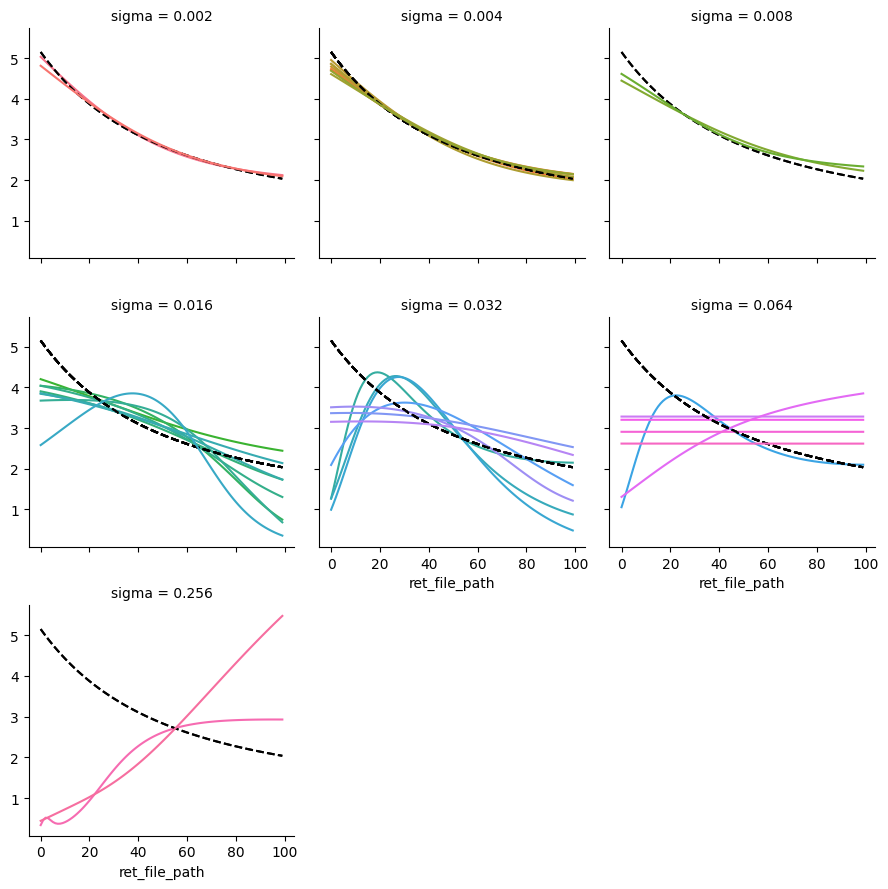

In [26]:
g = sns.FacetGrid(
    data=df,
    col="sigma",
    col_wrap=3,
    hue=MSE_threshold_type,
)


def plot_ret(ret_file_paths, *args, **kwargs):
    if analytical_retardation_type == "freundlich":
        plt.ylim(3, 5)
    plt.plot(analytical_retardation, "k--")
    for p in ret_file_paths:
        curve = np.load(p)
        plt.plot(curve, **kwargs)


g.map(plot_ret, "ret_file_path")
plt.show()